# Multi-Class Classification Deep Learning Model for Glass Identification Using Keras
### David Lowe
### November 8, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Glass Identification dataset is a multi-class classification situation where we are trying to predict one of several (more than two) possible outcomes.

INTRODUCTION: The dataset involves predicting, from USA Forensic Science Service, six types of glass; defined in terms of their oxide content (i.e. Na, Fe, K, etc). The study of classification of types of glass was also partly motivated by criminological investigation. At the scene of the crime, the glass left can be used as evidence…if it is correctly identified!

ANALYSIS: The baseline performance of the model achieved an average accuracy score of 65.00%. After tuning the hyperparameters, the best model processed the training dataset with an accuracy of 70.00%. Furthermore, the final model processed the test dataset with an accuracy of 68.52%, which indicated that we might have a variance problem. We need to gather more data or apply regularization techniques in training to narrow the variance gap before deploying the model in production.

CONCLUSION: For this dataset, the model built using Keras and TensorFlow achieved a satisfactory result and should be considered for future modeling activities.

Dataset Used: Glass Identification Data Set

Dataset ML Model: Multi-class classification with numerical attributes

Dataset Reference: [https://archive.ics.uci.edu/ml/datasets/glass+identification]

One potential source of performance benchmarks: [https://www.kaggle.com/uciml/glass]

Any deep-learning modeling project genrally can be broken down into about six major tasks:
0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Set the random seed number for reproducible results
seedNum = 888

In [3]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
import keras as K
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import np_utils
import pandas as pd
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
verbose = True
tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_kernel_init = K.initializers.RandomNormal(seed=seedNum)
default_loss = 'categorical_crossentropy'
default_optimizer = 'adam'
default_epochs = 500
default_batches = 8
default_metrics = ['accuracy']

Num GPUs Available:  0


In [5]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Multi-Class Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [6]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [7]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [8]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data'
colNames = ['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','targetVar']
Xy_original = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=0)

# Take a peek at the dataframe after the import
Xy_original.head(10)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,targetVar
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
7,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
8,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
9,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
10,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [9]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 10 columns):
RI           214 non-null float64
Na           214 non-null float64
Mg           214 non-null float64
Al           214 non-null float64
Si           214 non-null float64
K            214 non-null float64
Ca           214 non-null float64
Ba           214 non-null float64
Fe           214 non-null float64
targetVar    214 non-null int64
dtypes: float64(9), int64(1)
memory usage: 18.4 KB


In [10]:
Xy_original.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,targetVar
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [11]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

RI           0
Na           0
Mg           0
Al           0
Si           0
K            0
Ca           0
Ba           0
Fe           0
targetVar    0
dtype: int64
Total number of NaN in the dataframe:  0


## 1.b) Data Cleaning

In [12]:
# Standardize the class column to the name of targetVar if required
# Xy_original = Xy_original.rename(columns={'old_name': 'targetVar'})

# Dropping features
# Xy_original.drop(columns=['attribute_name'], inplace=True)

# Impute missing values
# Xy_original['col_name'].fillna('someValue', inplace=True)
# Xy_original['attribute_name'].fillna(value=Xy_original['attribute_name'].median(), inplace=True)

# Convert columns from one data type to another
# Xy_original.column_name = Xy_original.column_name.astype('int')
# Xy_original.column_name = Xy_original.column_name.astype('category')

# Convert features with Y/N levels into categorical feature of 1/0
# def reClassSomecol(target):
#     if (target == 'Y'): return 1
#     else: return 0
# Xy_original['targetVar'] = Xy_original['target'].apply(reClassSomecol)
# Xy_original.drop(columns=['target'], inplace=True)

# Take a peek at the dataframe after the cleaning
Xy_original.head(10)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,targetVar
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
7,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
8,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
9,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
10,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [13]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 10 columns):
RI           214 non-null float64
Na           214 non-null float64
Mg           214 non-null float64
Al           214 non-null float64
Si           214 non-null float64
K            214 non-null float64
Ca           214 non-null float64
Ba           214 non-null float64
Fe           214 non-null float64
targetVar    214 non-null int64
dtypes: float64(9), int64(1)
memory usage: 18.4 KB


In [14]:
Xy_original.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,targetVar
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [15]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

RI           0
Na           0
Mg           0
Al           0
Si           0
K            0
Ca           0
Ba           0
Fe           0
targetVar    0
dtype: int64
Total number of NaN in the dataframe:  0


## 1.c) Feature Scaling and Pre-processing

In [16]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [17]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (214, 10) X_original.shape: (214, 9) y_original.shape: (214,)


In [18]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

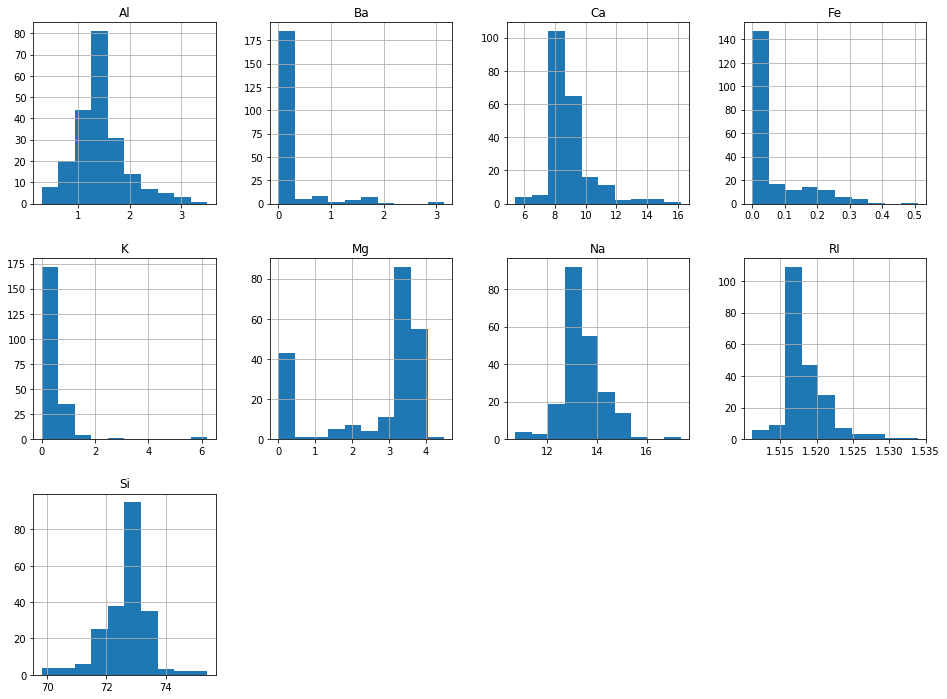

In [19]:
# Histograms for each attribute before pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [20]:
# Apply feature scaling and transformation

# X_original['some_feature'] = preprocessing.scale(X_original['some_feature'])
preprocessing.scale(X_original, copy=False)

array([[ 0.87286765,  0.28495326,  1.25463857, ..., -0.14576634,
        -0.35287683, -0.5864509 ],
       [-0.24933347,  0.59181718,  0.63616803, ..., -0.79373376,
        -0.35287683, -0.5864509 ],
       [-0.72131806,  0.14993314,  0.60142249, ..., -0.82894938,
        -0.35287683, -0.5864509 ],
       ...,
       [ 0.75404635,  1.16872135, -1.86551055, ..., -0.36410319,
         2.95320036, -0.5864509 ],
       [-0.61239854,  1.19327046, -1.86551055, ..., -0.33593069,
         2.81208731, -0.5864509 ],
       [-0.41436305,  1.00915211, -1.86551055, ..., -0.23732695,
         3.01367739, -0.5864509 ]])

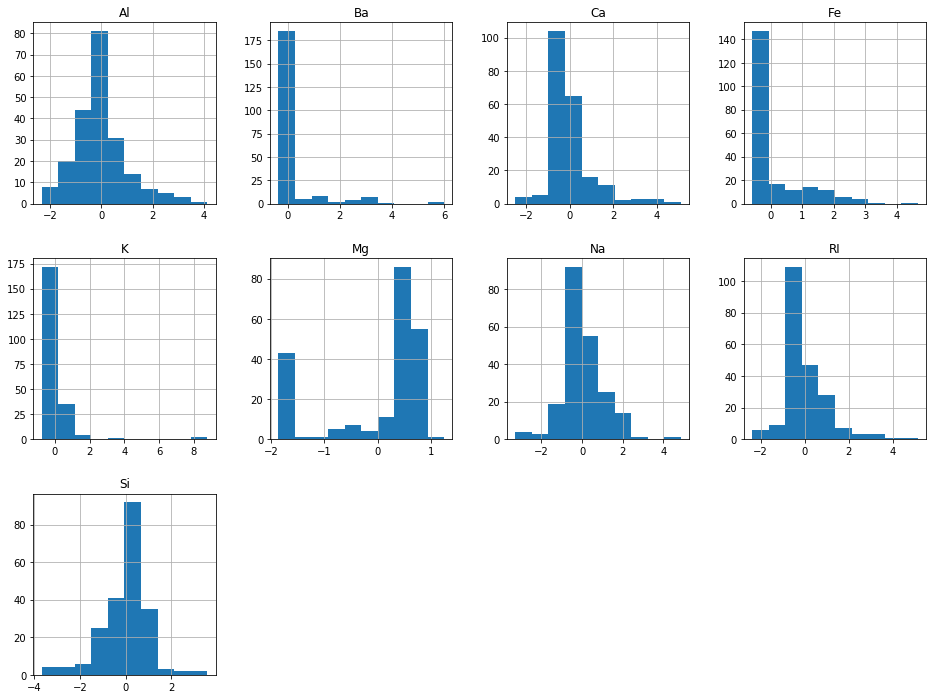

In [21]:
# Histograms for each attribute after pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

## 1.d) Splitting Data into Training and Test Sets

In [22]:
# Encode class values as integers and perform one-hot-encoding
encoder = preprocessing.LabelEncoder()
encoder.fit(y_original)
y_transformed = encoder.transform(y_original)
y_encoded = np_utils.to_categorical(y_transformed)
print(y_encoded)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [23]:
X_encoded = X_original.values
if (splitDataset):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, random_state=seedNum)
else:
    X_train, y_train = X_encoded, y_encoded
    X_test, y_test = X_encoded, y_encoded
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (160, 9) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (160, 6) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (54, 9) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (54, 6) y_test.type: <class 'numpy.ndarray'>


In [24]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Model

In [25]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [26]:
# Define the Keras model required for KerasClassifier
def create_default_model():
    default_model = K.models.Sequential()
    default_model.add(Dense(24, input_dim=9, kernel_initializer=default_kernel_init, activation='relu'))
    default_model.add(Dense(12, kernel_initializer=default_kernel_init, activation='relu'))
    default_model.add(Dense(6, kernel_initializer=default_kernel_init, activation='softmax'))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

In [27]:
# Initialize the Keras model
cv_model = KerasClassifier(build_fn=create_default_model, epochs=default_epochs, batch_size=default_batches, verbose=0)

In [28]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model

In [29]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [30]:
startTimeModule = datetime.now()

# Fit and evaluate the Keras model using 10-fold cross validation
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
results = cross_val_score(cv_model, X_train, y_train, cv=kfold)
print('Generating results using the metrics of', default_metrics)
print('All cross-Validate results:', results)
print('Baseline results [mean (std)]: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))

print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job

In [31]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Optimize Model

In [32]:
if (notifyStatus): email_notify("Phase 4 Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [33]:
# Define the Keras model required for KerasClassifier
def create_customized_model(optimizer, kernel_init):
    customized_model = K.models.Sequential()
    customized_model.add(Dense(24, input_dim=9, kernel_initializer=kernel_init, activation='relu'))
    customized_model.add(Dense(12, kernel_initializer=kernel_init, activation='relu'))
    customized_model.add(Dense(6, kernel_initializer=kernel_init, activation='softmax'))
    customized_model.compile(loss=default_loss, optimizer=optimizer, metrics=default_metrics)
    return customized_model

In [34]:
startTimeModule = datetime.now()

# create model
grid_model = KerasClassifier(build_fn=create_customized_model, verbose=0)

# Perform grid search using different epochs, batch sizes, and optimizers
optz_1 = K.optimizers.Adam(learning_rate=0.001)
optz_2 = K.optimizers.Adam(learning_rate=0.005)
optz_3 = K.optimizers.Adam(learning_rate=0.009)
optimizer_grid = [optz_1, optz_2, optz_3]
init_1 = K.initializers.RandomNormal(seed=seedNum)
init_2 = K.initializers.glorot_normal(seed=seedNum)
init_3 = K.initializers.Orthogonal(seed=seedNum)
init_grid = [init_1, init_2, init_3]
epoch_grid = [500, 1000, 1500]
batch_grid = [8, 16, 32]
param_grid = dict(optimizer=optimizer_grid, kernel_init=init_grid, epochs=epoch_grid, batch_size=batch_grid)
# grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, cv=n_folds, n_jobs=n_jobs, verbose=3)
n_iter = int(len(optimizer_grid) * len(init_grid) * len(epoch_grid) * len(batch_grid) * 0.5)
grid = RandomizedSearchCV(estimator=grid_model, param_distributions=param_grid, n_iter=n_iter, cv=n_folds, n_jobs=n_jobs, verbose=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

print('Total time for performing grid-search of the best parameters:', (datetime.now() - startTimeModule))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 16.2min finished


Executing op __inference_keras_scratch_graph_212355 in device /job:localhost/replica:0/task:0/device:CPU:0
Best: 0.700000 using {'optimizer': <keras.optimizers.Adam object at 0x7f5ec03d67d0>, 'kernel_init': <keras.initializers.RandomNormal object at 0x7f5ec03c2a50>, 'epochs': 1500, 'batch_size': 16}
0.643750 (0.098027) with: {'optimizer': <keras.optimizers.Adam object at 0x7f5ec03d67d0>, 'kernel_init': <keras.initializers.Orthogonal object at 0x7f5ec03c2090>, 'epochs': 1500, 'batch_size': 32}
0.693750 (0.107165) with: {'optimizer': <keras.optimizers.Adam object at 0x7f5ec03c2a10>, 'kernel_init': <keras.initializers.VarianceScaling object at 0x7f5ec03c22d0>, 'epochs': 1500, 'batch_size': 8}
0.675000 (0.112847) with: {'optimizer': <keras.optimizers.Adam object at 0x7f5ec03c2a10>, 'kernel_init': <keras.initializers.VarianceScaling object at 0x7f5ec03c22d0>, 'epochs': 500, 'batch_size': 16}
0.637500 (0.127475) with: {'optimizer': <keras.optimizers.Adam object at 0x7f5ec03c2990>, 'kernel_in

In [35]:
best_optimizer = grid_result.best_params_["optimizer"]
best_kernel_init = grid_result.best_params_["kernel_init"]
best_epoch = grid_result.best_params_["epochs"]
best_batch = grid_result.best_params_["batch_size"]

In [36]:
# Create the final model for evaluating the test dataset
print('Forming the final model using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
final_model = create_customized_model(best_optimizer, best_kernel_init)
final_model.fit(X_train, y_train, epochs=best_epoch, batch_size=best_batch, verbose=1)

Forming the final model using: optimizer=<keras.optimizers.Adam object at 0x7f5ec03d67d0>, kernel=<keras.initializers.RandomNormal object at 0x7f5ec03c2a50>, epochs=1500, batch_size=16
Epoch 1/1500
Executing op __inference_keras_scratch_graph_291274 in device /job:localhost/replica:0/task:0/device:CPU:0
160/160 [==============================] - 0s 2ms/step - loss: 1.7667 - accuracy: 0.3500
Epoch 2/1500
160/160 [==============================] - 0s 207us/step - loss: 1.6129 - accuracy: 0.3562
Epoch 3/1500
160/160 [==============================] - 0s 202us/step - loss: 1.3876 - accuracy: 0.4125
Epoch 4/1500
160/160 [==============================] - 0s 248us/step - loss: 1.2192 - accuracy: 0.4938
Epoch 5/1500
160/160 [==============================] - 0s 203us/step - loss: 1.0859 - accuracy: 0.5562
Epoch 6/1500
160/160 [==============================] - 0s 202us/step - loss: 0.9976 - accuracy: 0.6062
Epoch 7/1500
160/160 [==============================] - 0s 203us/step - loss: 0.9318 -

In [37]:
# Display a summary of the final model
print(final_model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 24)                240       
_________________________________________________________________
dense_20 (Dense)             (None, 12)                300       
_________________________________________________________________
dense_21 (Dense)             (None, 6)                 78        
Total params: 618
Trainable params: 618
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential_7', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_19', 'trainable': True, 'batch_input_shape': (None, 9), 'dtype': 'float32', 'units': 24, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.05, 'seed': 894}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_20', 'trainable': True, 'dtype': 'float32', 'units': 12, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.05, 'seed': 894}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'con

In [38]:
# Evaluate the Keras model on previously unseen data
scores = final_model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (final_model.metrics_names[1], scores[1]*100))
print("\n%s: %.2f" % (final_model.metrics_names[0], scores[0]))

Executing op __inference_keras_scratch_graph_369359 in device /job:localhost/replica:0/task:0/device:CPU:0
54/54 [==============================] - 0s 1ms/step

accuracy: 68.52%

loss: 5.52


In [39]:
if (notifyStatus): email_notify("Phase 4 Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Finalize Model

In [40]:
if (notifyStatus): email_notify("Phase 5 Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [41]:
# Make class predictions with the model
predictions = final_model.predict_classes(X_test)

# Summarize the first 20 cases
for i in range(20):
	print('Data item #%d predicted to be %s (expected %s)' % (i, encoder.inverse_transform([predictions[i]]), encoder.inverse_transform([np.argmax(y_test[i])])))

Executing op __inference_keras_scratch_graph_369396 in device /job:localhost/replica:0/task:0/device:CPU:0
Data item #0 predicted to be [2] (expected [1])
Data item #1 predicted to be [1] (expected [1])
Data item #2 predicted to be [1] (expected [1])
Data item #3 predicted to be [2] (expected [1])
Data item #4 predicted to be [3] (expected [6])
Data item #5 predicted to be [2] (expected [1])
Data item #6 predicted to be [2] (expected [2])
Data item #7 predicted to be [7] (expected [7])
Data item #8 predicted to be [1] (expected [1])
Data item #9 predicted to be [1] (expected [2])
Data item #10 predicted to be [2] (expected [2])
Data item #11 predicted to be [2] (expected [7])
Data item #12 predicted to be [1] (expected [1])
Data item #13 predicted to be [2] (expected [2])
Data item #14 predicted to be [3] (expected [1])
Data item #15 predicted to be [2] (expected [2])
Data item #16 predicted to be [2] (expected [2])
Data item #17 predicted to be [5] (expected [5])
Data item #18 predict

In [42]:
if (notifyStatus): email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [43]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:19:43.135812
